In [1]:
%matplotlib inline

# Load data

In [2]:
from nilearn import datasets
import csv
import pandas as pd

adhd_dataset = datasets.fetch_adhd(n_subjects=5)
func_filenames = adhd_dataset.func
confounds = adhd_dataset.confounds

/Users/rashina/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/rashina/anaconda3/lib/python3.6/site-packages/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [3]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')

# We show here networks of 64, 197, 444
networks_64 = parcellations['scale064']
networks_197 = parcellations['scale197']
networks_444 = parcellations['scale444']

# Get the correlation matrix and vectorize its upper triangular for all subjects

In [4]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=networks_64, standardize=True,
                           memory='nilearn_cache', verbose=5)

n_regions = 64
#Remember: you are using the networks_64 Basc
#Remember: confounds will be regressed out during signal extraction


#from nilearn import connectome and  sym_matrix_to_vec. The foremer will be used 
#to compute the correlation matrices and the latter to get the upper triangular of 
#each correlation matrix into a vector
from nilearn.connectome import ConnectivityMeasure, sym_matrix_to_vec
correlations = []
upper_triang_corrs = []

# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(func_filenames, confounds):
    timeseries_each_subject = masker.fit_transform(filename, confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)
    # get the upper triangular correlation matrix of correlation
    upper_triang_corr = sym_matrix_to_vec(correlation, discard_diagonal=False)
    # saving each subject upper_triang_corr to upper_triang_corrs
    upper_triang_corrs.append(upper_triang_corr)   

[NiftiLabelsMasker.fit_transform] loading data from /Users/rashina/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels
[Memory]    0.2s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


# Get the mean corerlation matrix across subjects and plot it

In [5]:
# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions,
                                                          n_regions)

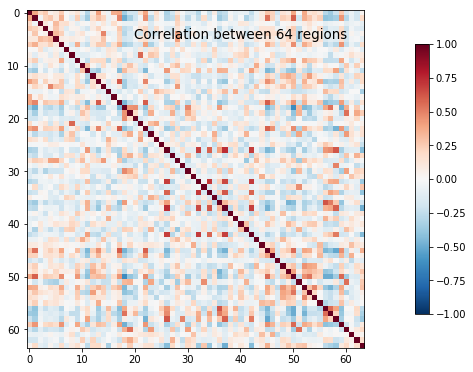

In [6]:
from nilearn import plotting
title = 'Correlation between %d regions' % n_regions

# First plot the matrix
display = plotting.plot_matrix(mean_correlations, vmax=1, vmin=-1,
                               colorbar=True, title=title)


In [7]:
#Exporting the the correlation matrix to CSV file - this will change when we get the specific paths
df_mean_correlations = pd.DataFrame(mean_correlations)
df_mean_correlations.to_csv('correlation_matrix.csv')
